## Car Classification with Vehicle dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the data

You're all set to download the data from [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). This dataset contains many files that are sorted by make, model, and year.

Only need to unzip the dataset file to the desired path a single time.

In [ ]:
#! unzip -q -n {path}/VMMRdb.zip -d {path}

Set the path that will be used access the dataset as well as the label information.

In [3]:
path = Path('/datastore/nvme/cars_data/')

PosixPath('/datastore/nvme/cars_data')

The below lines of code are used to remove the images from the respective model year folders and combine into one folder per model. This code will only need to be fun at the time of data setup.

In [ ]:
# len(os.listdir(str(path) + '/' + path_f)) == 0

In [ ]:
# import os 
# import pdb
# for filename in os.listdir(path):
#     #Folder_name is used to store the file name after the "Year" been removes
#     folder_name = filename.split("_", 2)[:-1]
#     if len(folder_name) > 1:
#         #New_folder_name is used to store the concat. value of the folder name without the "Year"
#         new_folder_name = folder_name[0] + "_" + folder_name[1]
#         #Path_new is used to create a new path name which can be used to store the Make & Model across "Years"
#         path_new = path/new_folder_name
#         #Checking if the folder already exists in the directory
#         if path_new not in os.listdir(path):
#             path_new.mkdir(exist_ok=True)
#             files = os.listdir(str(path)+'/'+filename)
#             for f in files:
#                 if f not in os.listdir(path_new):
#                     #pdb.set_trace()
#                     shutil.move(str(path)+'/'+ filename + '/' + f, path_new)
#         else:
#             files = os.listdir(str(path)+'/'+filename)
#             for f in files:
#                 if f not in os.listdir(path_new):
#                     #pdb.set_trace()
#                     shutil.move(str(path)+'/'+ filename + '/' + f, path_new)

File clean up directories which do not have less than 100 images as these a likely to be vehicles that are rare in occurance.

In [ ]:
# count = 0
# for filename in os.listdir(path):
#     if len(os.listdir(str(path) + '/' + filename)) < 100:        
#         shutil.rmtree(str(path) + '/' + filename, ignore_errors=True)
 

In [ ]:
# import pdb
# count = 0
# for f in os.listdir(path):
#     #pdb.set_trace()
#     x = str(path) + '/' + f
#     if len(os.listdir(x)) == 0:        
#         !rm -r {x}

In [ ]:
# shutil.rmtree(str(path) + '/' + filename, ignore_errors=True)

## Image Classification

Setting the transforms allows us to use them set what types of images transformations we will use on the image set to better genealize during trainning.

In [5]:
tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.1)

In [6]:
np.random.seed(42)
src = (ImageItemList.from_folder(path)
       .random_split_by_pct(0.2)
       .label_from_folder())

In [7]:
data = (src.transform(tfms, size=64)
        .databunch(bs=32).normalize(imagenet_stats))

Using show_batch we can look at the data to help validate that the labels make sense and are properly attributed to the correct iamges.

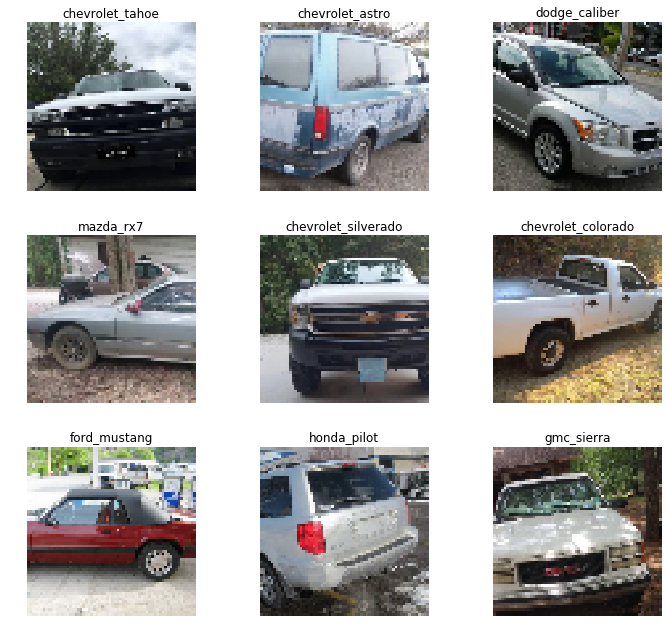

In [8]:
data.show_batch(rows=3, figsize=(10,9))

In [9]:
data.c

375

In [10]:
len(data.train_ds.y.classes)

375

Our base architecture is resnet34 and we will use the `error_rate` to messure the accuracy of our predictions.

In [11]:
arch = models.resnet34

In [12]:
learn = create_cnn(data, arch, metrics=[error_rate])

We use the LR Finder to pick a good learning rate.

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


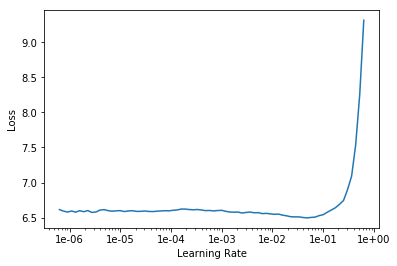

In [14]:
learn.recorder.plot()

Then we can fit the head of our network. These are the rows that have been added to the 

In [15]:
lr = 1e-3

In [16]:
learn.fit_one_cycle(5, slice(lr))

Total time: 30:22
epoch  train_loss  valid_loss  error_rate
1      4.660275    4.425320    0.885239    (05:59)
2      4.148457    3.826701    0.807478    (06:05)
3      3.955303    3.574643    0.768188    (06:06)
4      3.885371    3.436690    0.742919    (06:05)
5      3.742301    3.431929    0.739828    (06:05)



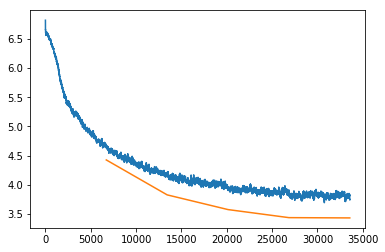

In [17]:
learn.recorder.plot_losses()

...And fine-tune the whole model:

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


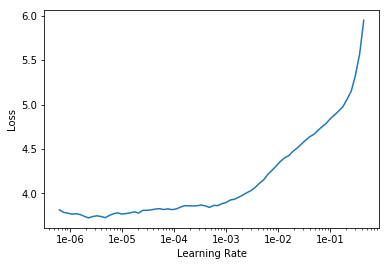

In [19]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
torch.cuda.empty_cache()

In [20]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

Total time: 37:37
epoch  train_loss  valid_loss  error_rate
1      3.304232    2.911348    0.651137    (07:29)
2      2.828344    2.436152    0.563860    (07:30)
3      2.388733    2.003760    0.474778    (07:31)
4      2.071037    1.713261    0.414688    (07:32)
5      1.818229    1.637569    0.397613    (07:32)



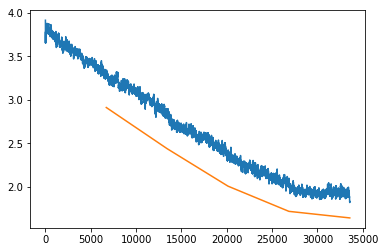

In [21]:
learn.recorder.plot_losses()

In [ ]:
torch.cuda.empty_cache()

In [25]:
data = (src.transform(tfms, size=128)
        .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [26]:
learn.freeze()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


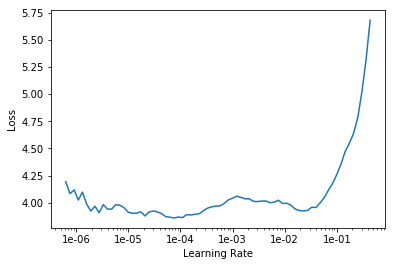

In [28]:
learn.recorder.plot()

In [29]:
lr =1e-5

In [30]:
learn.fit_one_cycle(10, slice(lr))

Total time: 1:39:56
epoch  train_loss  valid_loss  error_rate
1      3.811392    3.213463    0.686759    (10:00)
2      3.508908    2.892043    0.638251    (10:01)
3      3.244843    2.621048    0.590675    (10:02)
4      3.036868    2.444469    0.555891    (10:06)
5      2.990864    2.348903    0.534830    (10:08)
6      2.866411    2.281994    0.521572    (10:07)
7      2.830235    2.263120    0.516917    (10:09)
8      2.870465    2.231987    0.511107    (09:48)
9      2.910063    2.236621    0.513007    (09:44)
10     2.865307    2.225011    0.510381    (09:46)



In [31]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


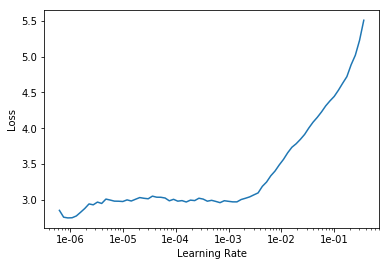

In [35]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.fit_one_cycle(10, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,error_rate
1,2.029943,1.579730,0.375342
2,1.864468,1.420564,0.339609


In [ ]:
learn.save('stage-2-128-rn34')

In [ ]:
learn.load('stage-2-128-rn34')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(3e-5, lr/5))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch(bs=6).normalize(imagenet_stats))
learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(8e-5, lr/5))

In [ ]:
learn.save('stage-2-256-rn50', return_path=True)

In [ ]:
learn.freeze()

In [ ]:
data = (src.transform(tfms, size=350)
        .databunch(bs=32).normalize(imagenet_stats))
learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-5

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(3e-5,lr/5))

In [ ]:
data.show_batch(rows=3, figsize=(10,9))

In [ ]:
predictions = learn.get_preds(ds_type=DatasetType.Train)

In [ ]:
len(predictions[0])

In [ ]:
def find_tags(pred, thresh):
    classes = ""
    for idx, val in enumerate(pred):
        if val > thresh:
            classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()

In [ ]:
def predict(idx):
    pred_vals = predictions[0][idx]
    tags = find_tags(pred_vals, 0.2)
    print(tags)
    img = learn.data.train_ds[idx][0]
    return img

In [ ]:
predict(84)

In [ ]:
def get_row(idx):
    pred = predictions[0][idx]
    tags = find_tags(pred, 0.2)
    image_path = learn.data.train_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags

In [ ]:
get_row(13)

In [ ]:
dk = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions[0])):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    dk.loc[idx] = [image_name, tags]

In [ ]:
dk

In [ ]:
data.train_ds.y.classes

# Putting Model into Production 

In [ ]:
import fastai
fastai.defaults.device = torch.device('cpu')

In [ ]:
classes = data.train_ds.y.classes

In [ ]:
len(classes)

In [ ]:
data2 = ImageDataBunch.single_from_classes(path/'cars_train', classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data2, models.resnet34).load('2-model')

In [ ]:
learn.predict(im)


In [ ]:
learn.path

In [ ]:
learn.model_dir

In [ ]:
learn.save('2-model', return_path=True)